### Time Series Prediction
In this notebook is to use time series models to predict future values of macroeconomic data. This future predictions will then be used for extrapolation of HDB resale prices into the next decade.

#### Load Libraries

In [1]:
# Wrangling libraries
import numpy as np
import pandas as pd

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning libraries
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")


/Users/gobind/.pyenv/versions/3.10.6/envs/hdb-price-estimator/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Create function to calculate mean absolute percentage error


In [832]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


#### Import and clean data

In [2]:
# Macroeconomic data
data = pd.read_csv('../data/processed/econdata_processed.csv')

# SG population data
sg_pop_df = pd.read_csv('../data/processed/singapore_population_1990_2023_v2.csv',index_col=0)
sg_pop_df = sg_pop_df[['key','ResidentPopulation']]

In [3]:
# create growth rate column
sg_pop_df['ResidentPopulation_Growth_Rate'] = sg_pop_df['ResidentPopulation'].pct_change(periods=1) * 100
sg_pop_df.loc[sg_pop_df['key'] == 1990, 'ResidentPopulation_Growth_Rate'] = sg_pop_df.loc[sg_pop_df['key'] == 1991, 'ResidentPopulation_Growth_Rate'].values


In [4]:
# merge dataframes
data = data.merge(sg_pop_df, how='left', left_on='Year', right_on='key')
data.head().T

,0,1,2,3,4
Date,1990-01-01,1990-02-01,1990-03-01,1990-04-01,1990-05-01
Quarter,1990 1Q,1990 1Q,1990 1Q,1990 2Q,1990 2Q
Year,1990,1990,1990,1990,1990
5 year bond yields,5.22,5.16,5.22,5.34,5.25
GDPm (Current Prices),16669.5,16669.5,16669.5,17087.7,17087.7
GDP per capita,22901.0,22901.0,22901.0,22901.0,22901.0
GNI per capita,23134.0,23134.0,23134.0,23134.0,23134.0
Personal Income m,9046.8,9046.8,9046.8,9460.3,9460.3
Unemployment Rate,1.8,1.8,1.8,1.8,1.8
Core inflation,61.59,61.7,61.48,61.86,61.99


In [5]:
# Drop columns deemed unnecessary
data = data.drop(columns=['  1-Room Residential Properties','  2-Room Residential Properties',
                          '  3-Room Residential Properties','  4-Room Residential Properties','  5-Room Residential Properties',
                          '  Executive Properties', 'Stamp Duty', 'LTV Value', 'yearly core inflation', 'yearly cement inflation',
                          'yearly clay inflation', 'key'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 16 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   Date                                                                           406 non-null    object 
 1   Quarter                                                                        406 non-null    object 
 2   Year                                                                           406 non-null    int64  
 3   5 year bond yields                                                             406 non-null    float64
 4   GDPm (Current Prices)                                                          406 non-null    float64
 5   GDP per capita                                                                 406 non-null    float64
 6   GNI per capita            

In [6]:
# Convert column type to date
data['Date'] = pd.to_datetime(data['Date'])

#### Split data into monthly, quarterly and yearly data

In [8]:
# Subset dataframe with lists of columns
monthly = data[['Date', '5 year bond yields', 'Core inflation',
                'Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials',
                'Clay Construction Materials & Refractory Construction Materials']]

quarterly = data[['Date', 'Quarter', 'GDPm (Current Prices)', 'Personal Income m']]

yearly = data[['Date', 'Year', 'GDP per capita', 'Unemployment Rate',
               'Median Household Inc', 'ResidentPopulation']]


### Predict Monthly Data

#### 5 year bond yields
- Five-year bond yields are closely tied to mortgage rates. As bond yields increase, mortgage rates typically rise, and vice versa.
- Higher bond yields lead to higher mortgage rates, making borrowing more expensive for buyers.
- Increased borrowing costs can reduce the demand for property, as higher mortgage rates decrease affordability.
- Lower demand due to higher mortgage rates can lead to a decrease in property prices. Conversely, lower mortgage rates can increase demand and push property prices up.
- Changes in bond yields can influence investor strategies in the real estate market, as they impact the cost of borrowing and potential returns.
- Fluctuations in five-year bond yields serve as indicators of potential trends in the real estate market, affecting both residential and commercial property sectors.

In [12]:
# create dataframe
bondyields = monthly[['Date', '5 year bond yields']]

# rename dataframe according to Prophet notation
bondyields.rename(columns={'Date':'ds','5 year bond yields':'y'}, inplace=True)
bondyields.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      406 non-null    datetime64[ns]
 1   y       406 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.5 KB


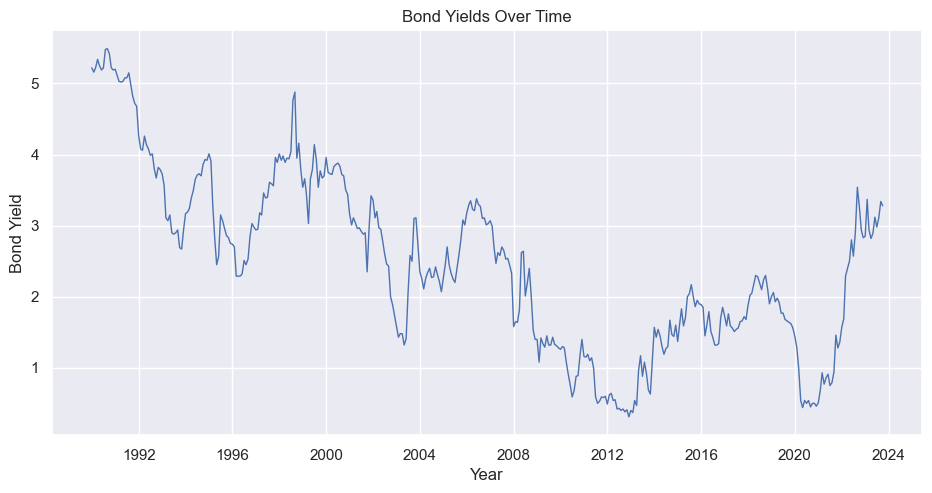

In [19]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=bondyields, x='ds', y='y', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Bond Yield')
plt.title('Bond Yields Over Time')
sns.set(style="darkgrid")
# Show the plot
plt.show()


In [20]:
# train model
bondyields_model = Prophet()
bondyields_model.fit(bondyields)


11:38:39 - cmdstanpy - INFO - Chain [1] start processing
11:38:40 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
# predict future values based on trained model
bondyields_future = bondyields_model.make_future_dataframe(periods=10*12+2, freq='MS', include_history=False)
bondyields_forecast = bondyields_model.predict(bondyields_future)
bondyields_forecast.head().T

,0,1,2,3,4
ds,2023-11-01 00:00:00,2023-12-01 00:00:00,2024-01-01 00:00:00,2024-02-01 00:00:00,2024-03-01 00:00:00
trend,1.978767,1.98459,1.990608,1.996625,2.002255
yhat_lower,1.194623,1.168392,1.166547,1.068803,1.010371
yhat_upper,2.879377,2.91418,2.793393,2.861329,2.846958
trend_lower,1.978767,1.98459,1.990608,1.996428,2.001759
trend_upper,1.978767,1.98459,1.990608,1.9968,2.002687
additive_terms,0.040672,0.036636,-0.009532,-0.029001,-0.077091
additive_terms_lower,0.040672,0.036636,-0.009532,-0.029001,-0.077091
additive_terms_upper,0.040672,0.036636,-0.009532,-0.029001,-0.077091
yearly,0.040672,0.036636,-0.009532,-0.029001,-0.077091


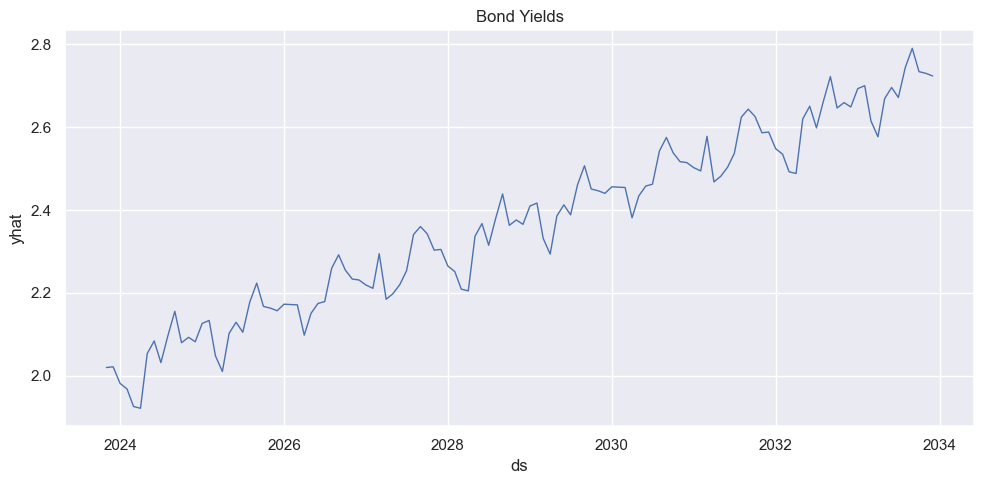

In [28]:
# Setting the plot size
plt.figure(figsize=(10, 5))
sns.lineplot(data=bondyields_forecast, x='ds', y='yhat', linewidth=1)
plt.title('Bond Yields')
#plt.ylim(bottom=0)
plt.tight_layout()
plt.show()


In [29]:
# extract only relevant columns
bondyields_forecast = bondyields_forecast[['ds', 'yhat']]


#### Core Inflation
- Core inflation, which excludes volatile food and energy prices, often correlates with increases in property values. 
- As inflation rises, the value of currency decreases, which can make tangible assets like property more valuable.
- In periods of high inflation, central banks may increase interest rates to control inflation. Higher interest rates lead to higher mortgage rates, potentially making borrowing more expensive for homebuyers.
- Increased borrowing costs can decrease the affordability of properties, leading to reduced demand. This can have a moderating effect on property price growth.
- Core inflation can increase the cost of construction materials and labor. This increase in development costs can lead to higher property prices, as new constructions become more expensive to complete.
- Property can maintain its real value during inflationary times, making it a preferred investment choice for preserving capital value in the long term.

In [30]:
# create dataframe
coreinf = monthly[['Date', 'Core inflation']]

# rename dataframe according to Prophet notation
coreinf.rename(columns={'Date':'ds','Core inflation':'y'}, inplace=True)


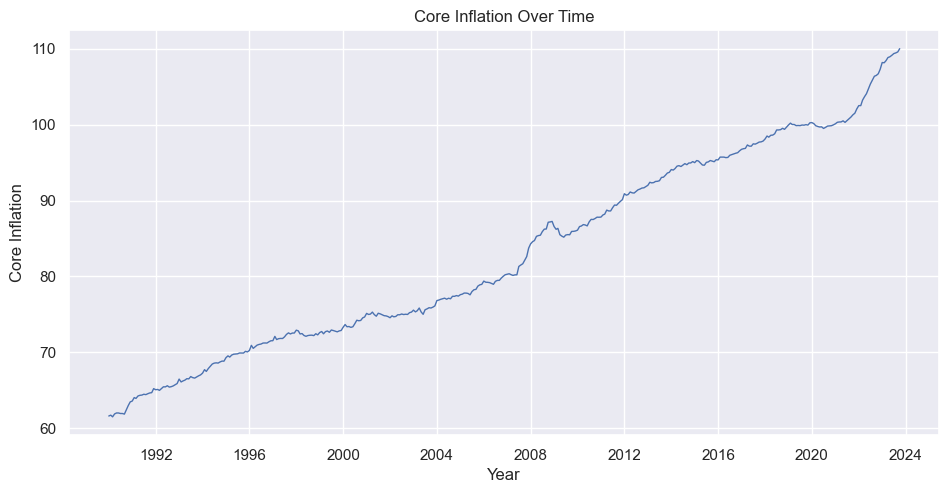

In [31]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=coreinf, x='ds', y='y', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Core Inflation')
plt.title('Core Inflation Over Time')
sns.set(style="darkgrid")
# Show the plot
plt.show()

In [32]:
# train model
coreinf_model = Prophet()
coreinf_model.fit(coreinf)


12:17:48 - cmdstanpy - INFO - Chain [1] start processing


12:17:48 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
# predict future values based on trained model
coreinf_future = coreinf_model.make_future_dataframe(periods=10*12+2, freq='MS', include_history=False)
coreinf_forecast = coreinf_model.predict(coreinf_future)


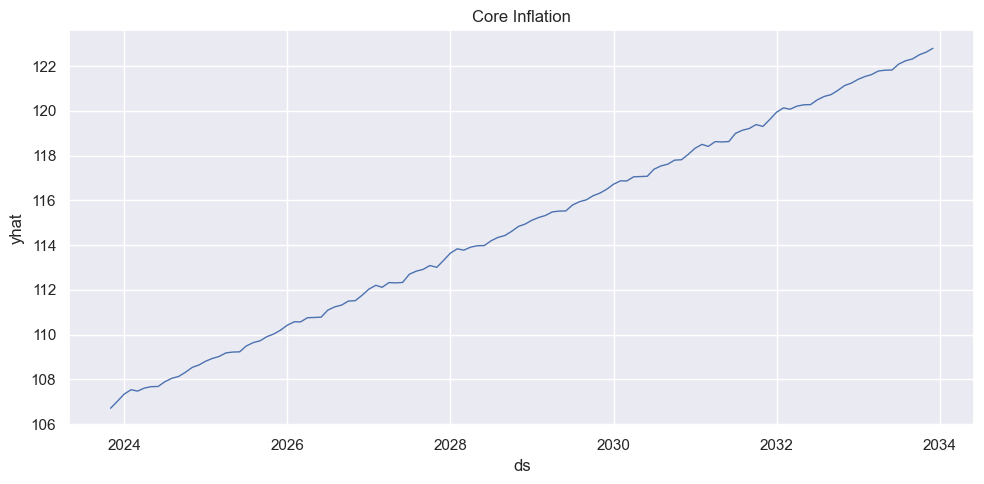

In [43]:
# Setting the plot size
plt.figure(figsize=(10, 5))
sns.lineplot(data=coreinf_forecast, x='ds', y='yhat', linewidth=1)
plt.title('Core Inflation')
#plt.ylim(bottom=0)
plt.tight_layout()
plt.show()


In [35]:
# extract only relevant columns
coreinf_forecast = coreinf_forecast[['ds', 'yhat']]


#### Predict Cement Inflation
- Inflation in cement prices directly increases the cost of construction. 
- As cement is a fundamental material in building, higher cement prices raise the overall expenses in constructing new homes and commercial buildings. 
- Developers and builders pass on the increased costs to buyers, resulting in more expensive real estate.
- If cement inflation is significant, it can slow down new construction projects due to increased costs, leading to a reduced supply of new homes in the market.
- Persistent and high cement inflation can lead to delays in construction projects as developers may wait for prices to stabilize, further impacting the supply and availability of new properties.

In [37]:
# create dataframe
cementinflation = monthly[['Date', 'Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials']]

# rename dataframe according to Prophet notation
cementinflation.rename(columns={'Date':'ds','Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials':'y'}, inplace=True)


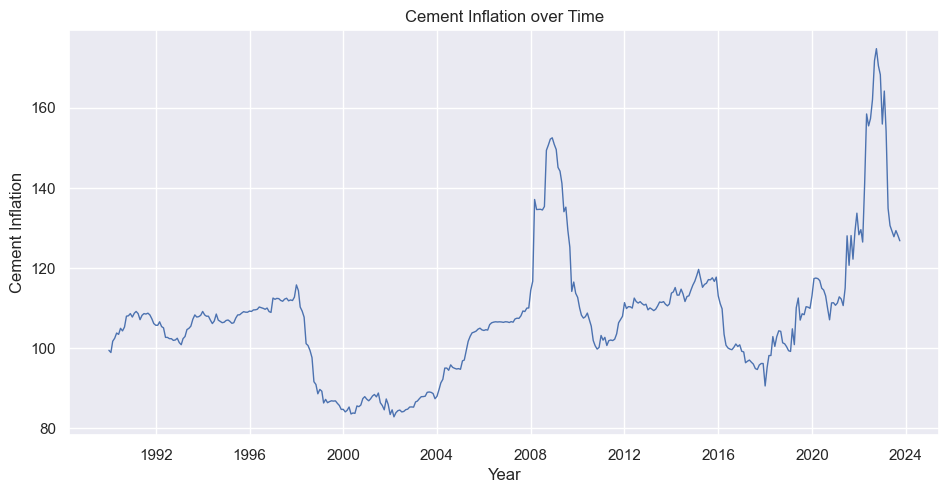

In [38]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=cementinflation, x='ds', y='y', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Cement Inflation')
plt.title('Cement Inflation over Time')
sns.set(style="darkgrid")
plt.show()

In [39]:
# train model
cementinflation_model = Prophet()
cementinflation_model.fit(cementinflation)


12:30:51 - cmdstanpy - INFO - Chain [1] start processing


12:30:51 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
# predict future values based on trained model
cementinflation_future = cementinflation_model.make_future_dataframe(periods=10*12+2, freq='MS', include_history=False)
cementinflation_forecast = cementinflation_model.predict(cementinflation_future)


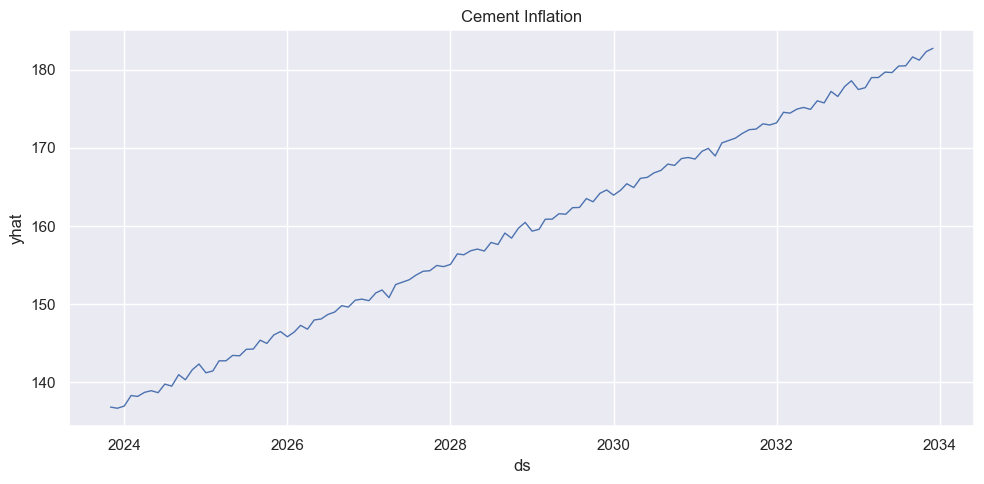

In [41]:
# Setting the plot size
plt.figure(figsize=(10, 5))
sns.lineplot(data=cementinflation_forecast, x='ds', y='yhat', linewidth=1)
plt.title('Cement Inflation')
#plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

In [42]:
# extract only relevant columns
cementinf_forecast = cementinflation_forecast[['ds', 'yhat']]


#### Predict Clay Inflation
- As clay is a crucial component in bricks, tiles, and other building materials, inflation in clay prices directly raises the cost of these materials.
- The increase in the cost of clay-based materials leads to higher overall construction costs.
- Increased construction costs results in an increased selling prices.
- If the rise in clay prices is substantial and sustained, it can lead to a slowdown in construction activity, potentially resulting in a decreased supply of new housing in the market, further raising prices.

In [44]:
# create dataframe
clayinf = monthly[['Date', 'Clay Construction Materials & Refractory Construction Materials']]

# rename dataframe according to Prophet notation
clayinf.rename(columns={'Date':'ds','Clay Construction Materials & Refractory Construction Materials':'y'}, inplace=True)


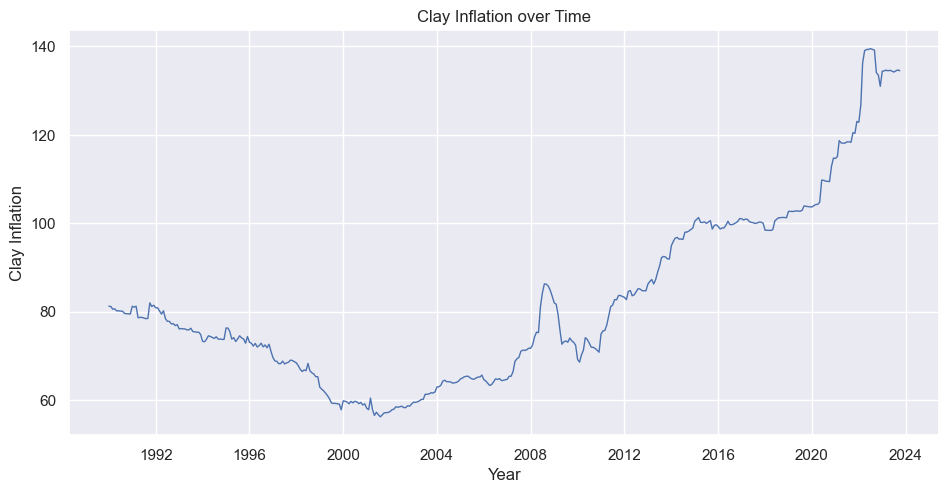

In [45]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=clayinf, x='ds', y='y', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Clay Inflation')
plt.title('Clay Inflation over Time')
sns.set(style="darkgrid")
plt.show()

In [46]:
# train model
clayinf_model = Prophet()
clayinf_model.fit(clayinf)


12:35:50 - cmdstanpy - INFO - Chain [1] start processing


12:35:50 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# predict future values based on trained model
clayinf_future = clayinf_model.make_future_dataframe(periods=10*12+2, freq='MS', include_history=False)
clayinf_forecast = clayinf_model.predict(clayinf_future)


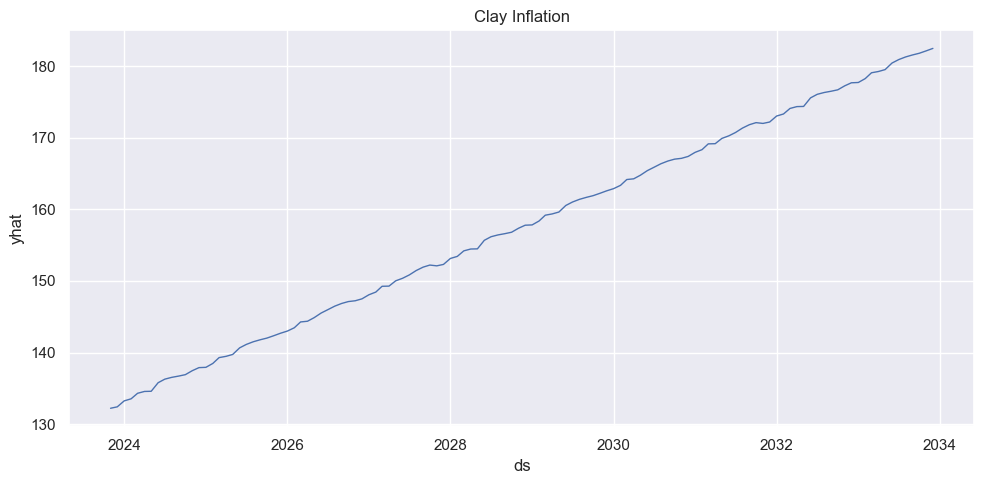

In [48]:
# Setting the plot size
plt.figure(figsize=(10, 5))
sns.lineplot(data=clayinf_forecast, x='ds', y='yhat', linewidth=1)
plt.title('Clay Inflation')
#plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

In [49]:
# extract only relevant columns
clay_forecast = clayinf_forecast[['ds', 'yhat']]


#### Merge monthly predicted data

In [50]:
# Rename Columns
bondyields_forecast.rename(columns={'yhat': '5 year bond yields'}, inplace=True)
coreinf_forecast.rename(columns={'yhat': 'Core inflation'}, inplace=True)
cementinf_forecast.rename(columns={'yhat': 'Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials'}, inplace=True)
clayinf_forecast.rename(columns={'yhat': 'Clay Construction Materials & Refractory Construction Materials'}, inplace=True)


In [51]:
# Merge data on ds
merged_df = pd.merge(bondyields_forecast, coreinf_forecast, on='ds')
merged_df = pd.merge(merged_df, cementinf_forecast, on='ds')
monthly_df = pd.merge(merged_df, clayinf_forecast, on='ds')

# Subset Df
monthly_df = monthly_df[['ds', '5 year bond yields', 'Core inflation', 'Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials', 'Clay Construction Materials & Refractory Construction Materials']]

# View
monthly_df.head().T

,0,1,2,3,4
ds,2023-11-01 00:00:00,2023-12-01 00:00:00,2024-01-01 00:00:00,2024-02-01 00:00:00,2024-03-01 00:00:00
5 year bond yields,2.019439,2.021226,1.981075,1.967625,1.925164
Core inflation,106.711467,107.016147,107.346275,107.53842,107.477876
"Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials",136.805831,136.655762,136.930404,138.284902,138.171993
Clay Construction Materials & Refractory Construction Materials,132.214363,132.412104,133.245327,133.53425,134.305669


### Predict Quarterly Data

In [52]:
# create dataframe with relevant quarterly data
quarterly = data[['Date', 'Quarter', 'GDPm (Current Prices)', 'Personal Income m']]
quarterly = quarterly.iloc[::3]
quarterly.head()


,Date,Quarter,GDPm (Current Prices),Personal Income m
0,1990-01-01,1990 1Q,16669.5,9046.8
3,1990-04-01,1990 2Q,17087.7,9460.3
6,1990-07-01,1990 3Q,17930.1,9962.4
9,1990-10-01,1990 4Q,18805.0,10073.9
12,1991-01-01,1991 1Q,18521.0,10509.5


#### GDPm (Current Prices)
- Nominal GDP reflects the overall economic health and growth. 
- When GDP grows, it often correlates with higher income levels, potentially boosting demand for real estate.
- Nominal GDP includes inflation. High inflation can lead to increases in property prices as part of the broader inflationary trend across various sectors.
- Positive GDP growth can lead to increased construction and development activities to meet the rising demand for real estate.


In [53]:
# create dataframe
gdpm = quarterly[['Date', 'GDPm (Current Prices)']]

# rename dataframe according to Prophet notation
gdpm.rename(columns={'Date':'ds','GDPm (Current Prices)':'y'}, inplace=True)


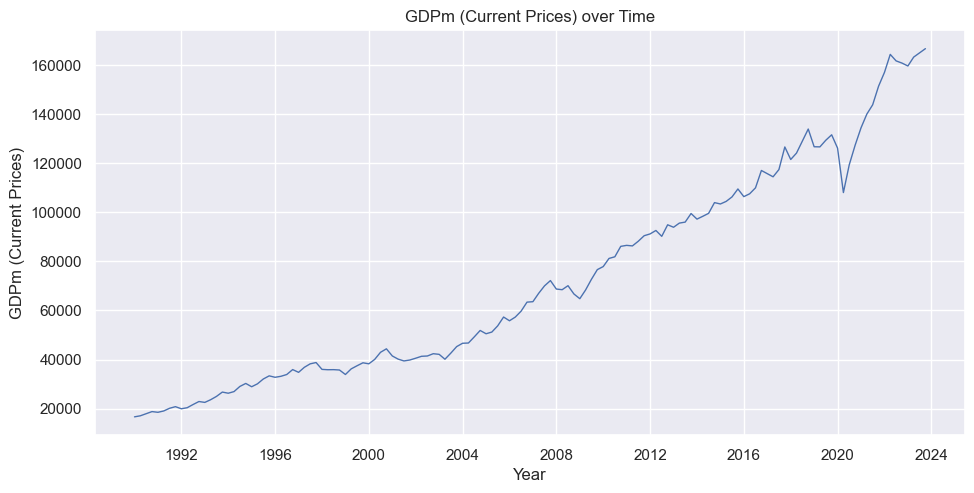

In [54]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=gdpm, x='ds', y='y', linewidth=1)
plt.xlabel('Year')
plt.ylabel('GDPm (Current Prices)')
plt.title('GDPm (Current Prices) over Time')
sns.set(style="darkgrid")
plt.show()

In [55]:
# train model
gdpm_model = Prophet()
gdpm_model.fit(gdpm)


12:47:35 - cmdstanpy - INFO - Chain [1] start processing


12:47:35 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
# predict future values based on trained model
gdpm_future = gdpm_model.make_future_dataframe(periods=10*4, freq='QS', include_history=False)
gdpm_forecast = gdpm_model.predict(gdpm_future)


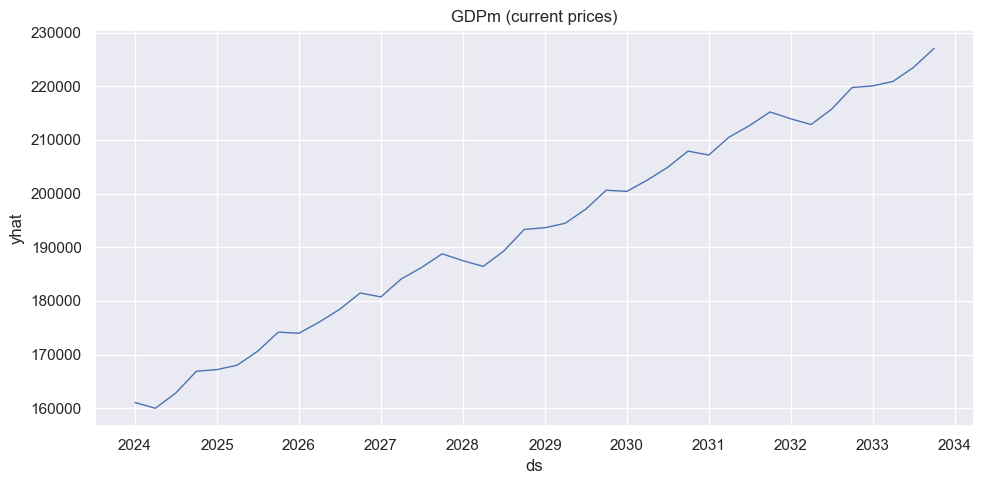

In [57]:
# Setting the plot size
plt.figure(figsize=(10, 5))
sns.lineplot(data=gdpm_forecast, x='ds', y='yhat', linewidth=1)
plt.title('GDPm (current prices)')
#plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

In [58]:
# extract only relevant columns
gdpm_forecast = gdpm_forecast[['ds', 'yhat']]


#### Predict Personal Income (m) prices
- Higher personal income generally increases the purchasing power of individuals, enabling them to afford more expensive properties.
- As personal incomes rise, the demand for housing often increases, as more people can afford to buy homes, which can drive up property prices.
- With higher disposable incomes, individuals are more likely to invest in real estate as a means of wealth accumulation or for rental income, further boosting property prices.

In [59]:
# create dataframe
personalinc = quarterly[['Date', 'Personal Income m']]

# rename dataframe according to Prophet notation
personalinc.rename(columns={'Date':'ds','Personal Income m':'y'}, inplace=True)


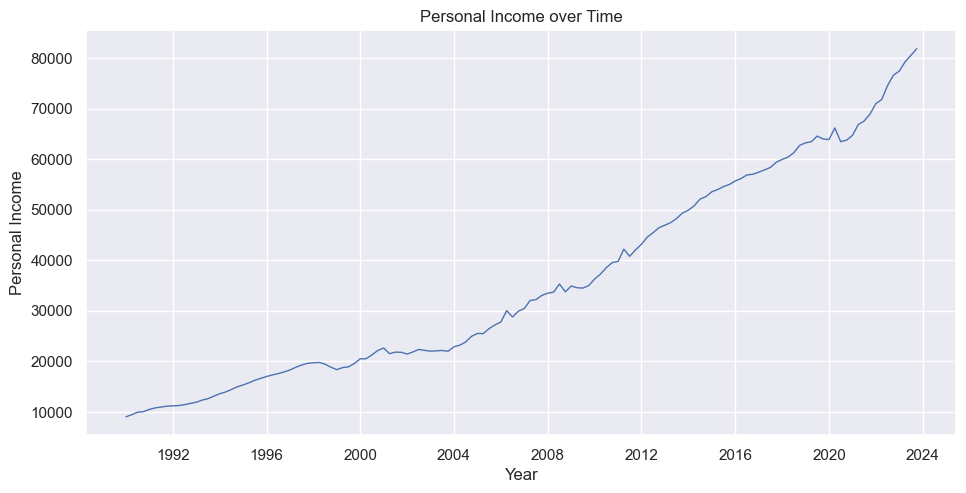

In [60]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=personalinc, x='ds', y='y', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Personal Income')
plt.title('Personal Income over Time')
sns.set(style="darkgrid")
plt.show()

In [61]:
# train model
personalinc_model = Prophet()
personalinc_model.fit(personalinc)


12:49:15 - cmdstanpy - INFO - Chain [1] start processing
12:49:15 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
# predict future values based on trained model
personalinc_future = personalinc_model.make_future_dataframe(periods=10*4, freq='QS', include_history=False)
personalinc_forecast = personalinc_model.predict(personalinc_future)


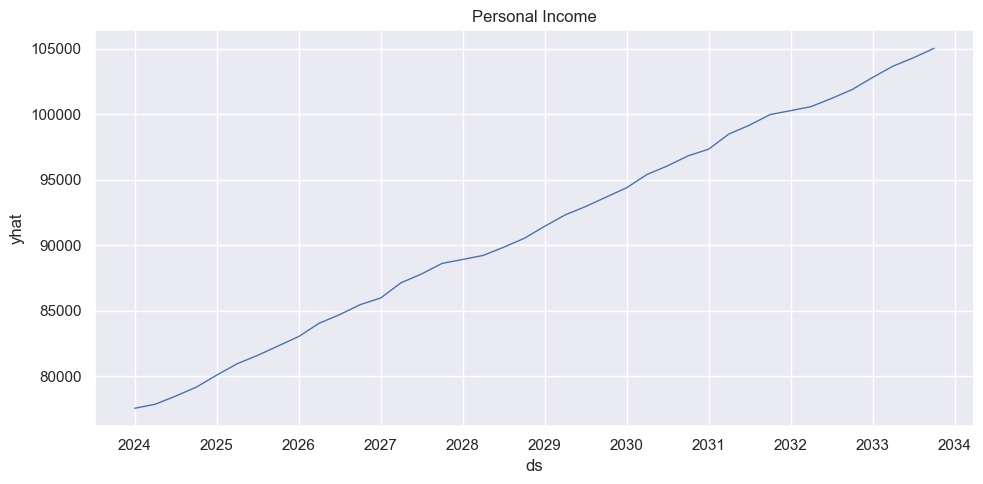

In [63]:
# Setting the plot size
plt.figure(figsize=(10, 5))
sns.lineplot(data=personalinc_forecast, x='ds', y='yhat', linewidth=1)
plt.title('Personal Income')
#plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

In [64]:
# extract only relevant columns
personalinc_forecast = personalinc_forecast[['ds', 'yhat']]


### Combine quarterly data

In [65]:
# Rename Columns
gdpm_forecast.rename(columns={'yhat': 'GDPm (Current Prices)'}, inplace=True)
personalinc_forecast.rename(columns={'yhat': 'Personal Income m'}, inplace=True)


In [66]:
# Merge dfs
quarterly_df = pd.merge(gdpm_forecast, personalinc_forecast, on='ds')

quarterly_df['Quarter'] = quarterly_df['ds'].dt.to_period('Q').dt.strftime('Q%q %Y')

quarterly_df = quarterly_df [['ds','Quarter', 'GDPm (Current Prices)','Personal Income m']]


### Predict yearly data

In [67]:
# Get yearly data
yearly = yearly.iloc[::12]
yearly.columns

Index(['Date', 'Year', 'GDP per capita', 'Unemployment Rate',
       'Median Household Inc', 'ResidentPopulation'],
      dtype='object')

#### Predicting GDP per capita
- GDP reflects the overall economic health and growth. 
- When GDP grows, it often correlates with higher income levels, potentially boosting demand for real estate.
- Nominal GDP includes inflation. High inflation can lead to increases in property prices as part of the broader inflationary trend across various sectors.
- Positive GDP growth can lead to increased construction and development activities to meet the rising demand for real estate.

In [68]:
# create dataframe
gdpcap = yearly[['Date', 'GDP per capita']]

# rename dataframe according to Prophet notation
gdpcap.rename(columns={'Date':'ds','GDP per capita':'y'}, inplace=True)


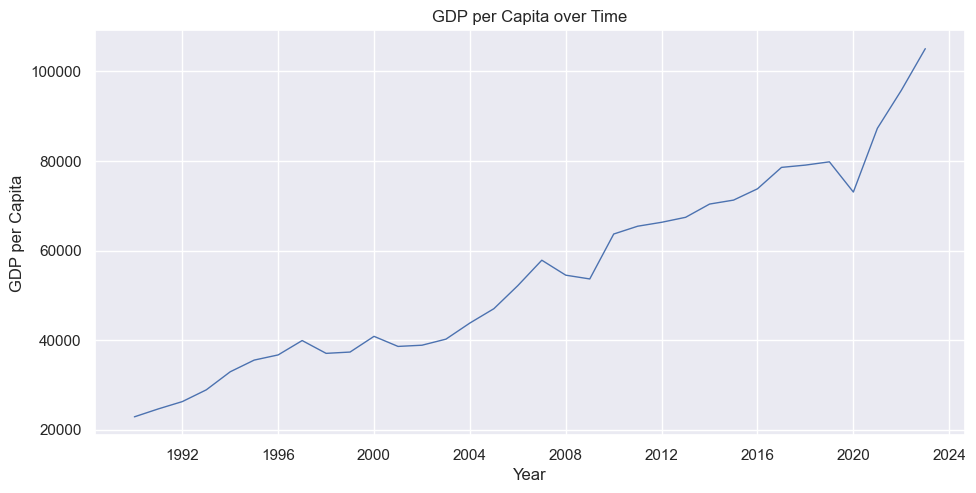

In [69]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=gdpcap, x='ds', y='y', linewidth=1)
plt.xlabel('Year')
plt.ylabel('GDP per Capita')
plt.title('GDP per Capita over Time')
sns.set(style="darkgrid")
plt.show()

In [70]:
# train model
gdpcap_model = Prophet()
gdpcap_model.fit(gdpcap)


12:52:24 - cmdstanpy - INFO - Chain [1] start processing


12:52:24 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
# predict future values based on trained model
gdpcap_future = gdpcap_model.make_future_dataframe(periods=10, freq='YS', include_history=False)
gdpcap_forecast = gdpcap_model.predict(gdpcap_future)


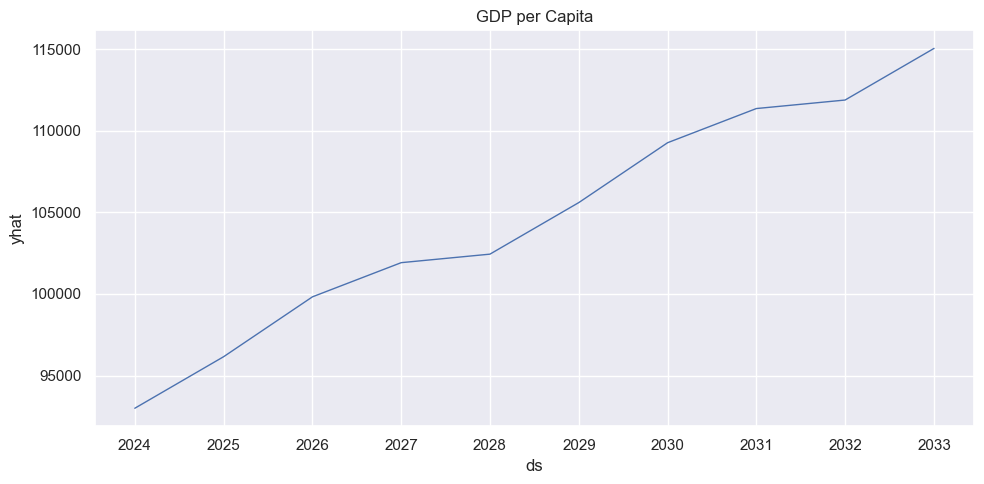

In [73]:
# Setting the plot size
plt.figure(figsize=(10, 5))
sns.lineplot(data=gdpcap_forecast, x='ds', y='yhat', linewidth=1)
plt.title('GDP per Capita')
#plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

In [74]:
# extract only relevant columns
gdpcap_forecast = gdpcap_forecast[['ds', 'yhat']]


#### Predict Unemployment Rate
- An increase in unemployment usually results in lower demand for housing, as fewer people have the financial stability to purchase property.
- Decreased demand due to rising unemployment can exert downward pressure on property prices.
- Higher unemployment can lead to more homeowners struggling with mortgage payments, potentially leading to increased foreclosures and a further increase in housing supply.

In [75]:
# create dataframe
unemp = yearly[['Date', 'Unemployment Rate']]

# rename dataframe according to Prophet notation
unemp.rename(columns={'Date':'ds','Unemployment Rate':'y'}, inplace=True)


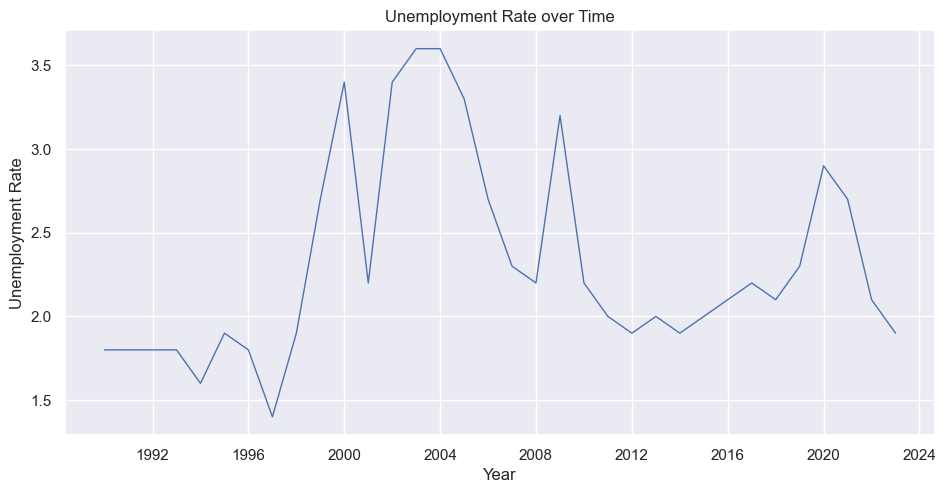

In [76]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=unemp, x='ds', y='y', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment Rate over Time')
sns.set(style="darkgrid")
plt.show()

In [77]:
# train model
unemp_model = Prophet()
unemp_model.fit(unemp)


12:53:38 - cmdstanpy - INFO - Chain [1] start processing


12:53:38 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
# predict future values based on trained model
unemp_future = unemp_model.make_future_dataframe(periods=10, freq='YS', include_history=False)
unemp_forecast = unemp_model.predict(unemp_future)


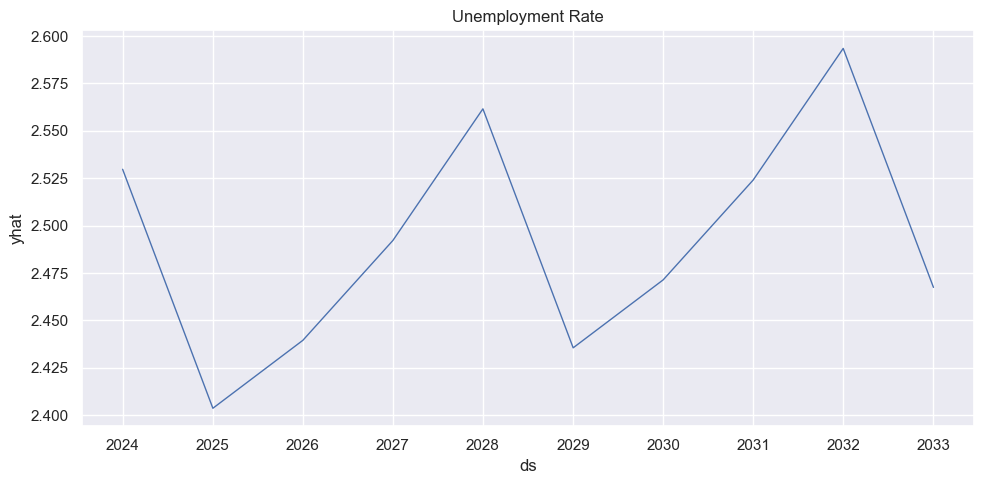

In [79]:
# Setting the plot size
plt.figure(figsize=(10, 5))
sns.lineplot(data=unemp_forecast, x='ds', y='yhat', linewidth=1)
plt.title('Unemployment Rate')
#plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

In [80]:
# extract only relevant columns
unemp_forecast = unemp_forecast[['ds', 'yhat']]


#### Predict Median Household Income
- Higher income generally increases the purchasing power of individuals, enabling them to afford more expensive properties.
- As incomes rise, the demand for housing often increases, as more people can afford to buy homes, which can drive up property prices.
- With higher disposable incomes, individuals are more likely to invest in real estate as a means of wealth accumulation or for rental income, further boosting property prices.

In [81]:
# create dataframe
medianinc = yearly[['Date', 'Median Household Inc']]

# rename dataframe according to Prophet notation
medianinc.rename(columns={'Date':'ds','Median Household Inc':'y'}, inplace=True)


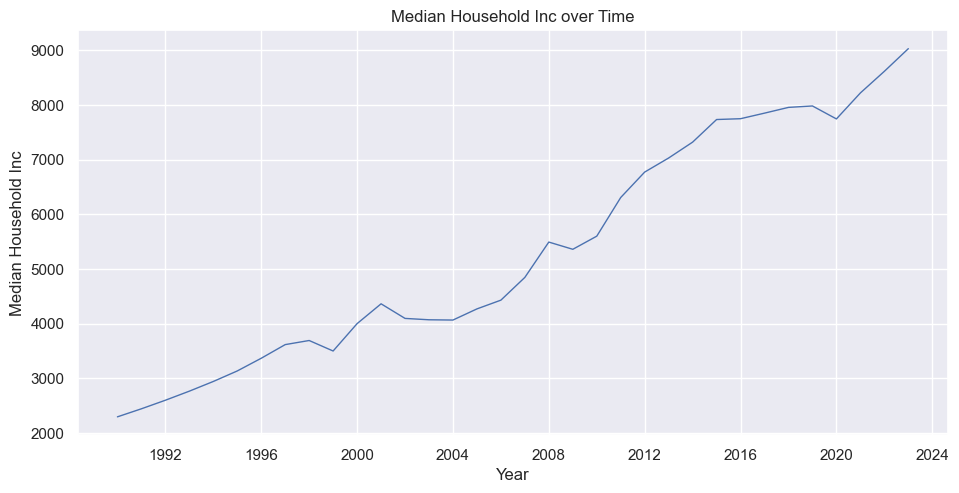

In [82]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=medianinc, x='ds', y='y', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Median Household Inc')
plt.title('Median Household Inc over Time')
sns.set(style="darkgrid")
plt.show()

In [83]:
# train model
medianinc_model = Prophet()
medianinc_model.fit(medianinc)


12:55:00 - cmdstanpy - INFO - Chain [1] start processing


12:55:00 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
# predict future values based on trained model
medianinc_future = medianinc_model.make_future_dataframe(periods=10, freq='YS', include_history=False)
medianinc_forecast = medianinc_model.predict(medianinc_future)


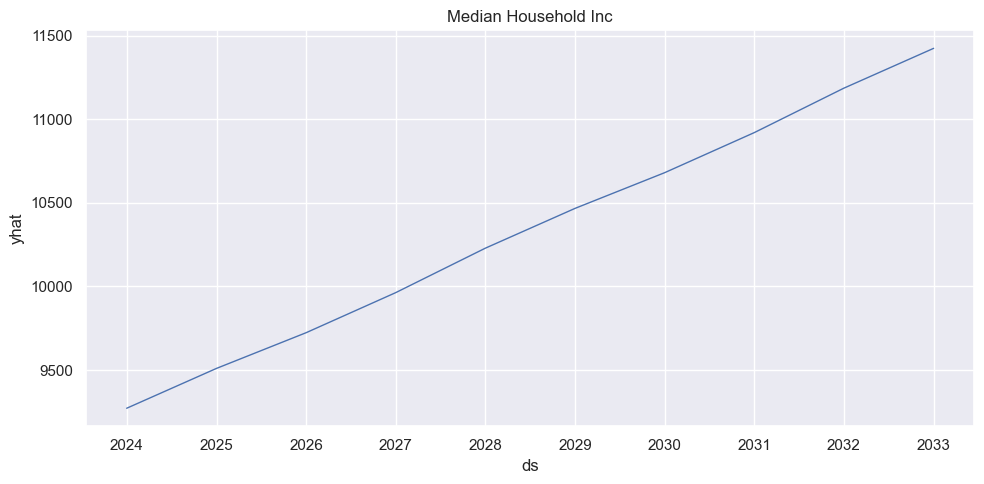

In [85]:
# Setting the plot size
plt.figure(figsize=(10, 5))
sns.lineplot(data=medianinc_forecast, x='ds', y='yhat', linewidth=1)
plt.title('Median Household Inc')
#plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

In [86]:
# extract only relevant columns
medianinc_forecast = medianinc_forecast[['ds', 'yhat']]


#### Predict Resident Population
- An increasing resident population typically leads to higher demand for housing, as more people require accommodation. This increased demand can drive up property prices.
- A growing population often results in diverse housing needs, potentially influencing the types and prices of properties that are in demand.
- Population growth can lead to the development of infrastructure and amenities, making certain areas more desirable and potentially increasing property values in those locations.

In [87]:
# create dataframe
respop = yearly[['Date', 'ResidentPopulation']]

# rename dataframe according to Prophet notation
respop.rename(columns={'Date':'ds','ResidentPopulation':'y'}, inplace=True)


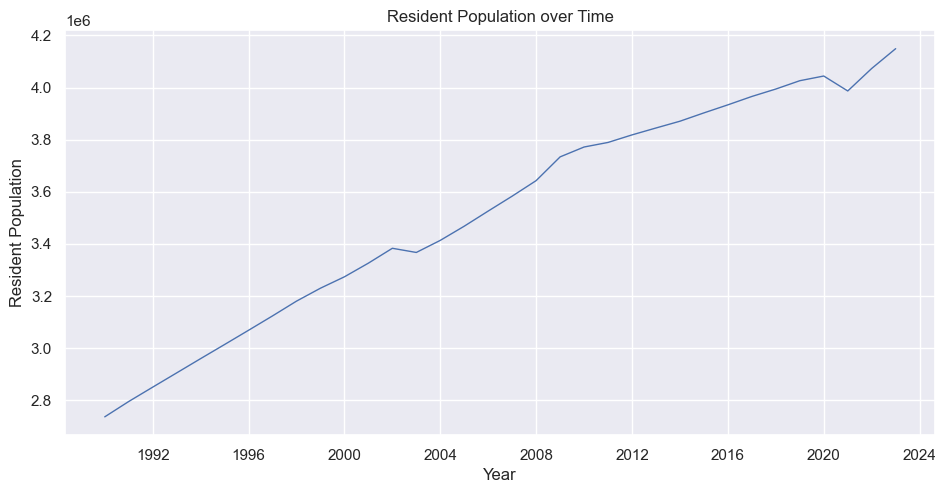

In [88]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=respop, x='ds', y='y', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Resident Population')
plt.title('Resident Population over Time')
sns.set(style="darkgrid")
plt.show()

In [89]:
# train model
respop_model = Prophet()
respop_model.fit(respop)


12:55:59 - cmdstanpy - INFO - Chain [1] start processing


12:55:59 - cmdstanpy - INFO - Chain [1] done processing


In [90]:
# predict future values based on trained model
respop_future = respop_model.make_future_dataframe(periods=10, freq='YS', include_history=False)
respop_forecast = respop_model.predict(respop_future)


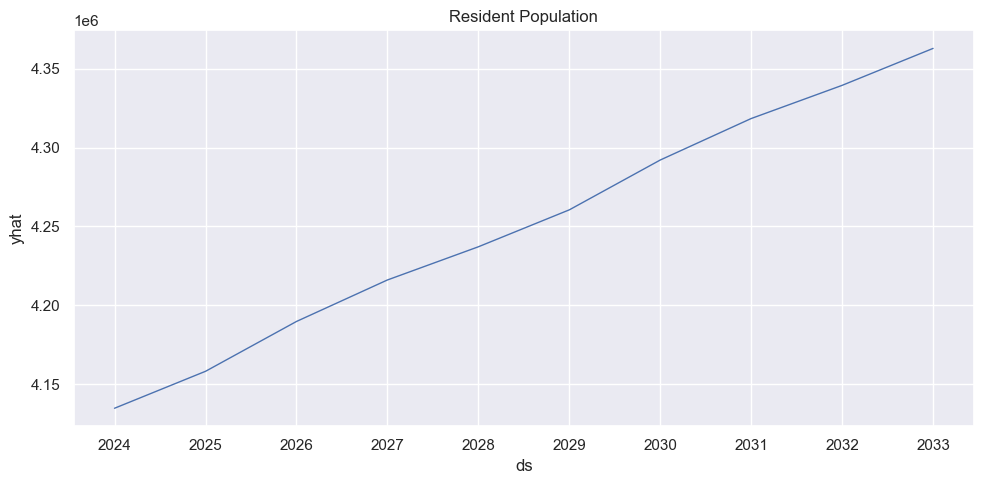

In [91]:
# Setting the plot size
plt.figure(figsize=(10, 5))
sns.lineplot(data=respop_forecast, x='ds', y='yhat', linewidth=1)
plt.title('Resident Population')
#plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

In [92]:
# extract only relevant columns
respop_forecast = respop_forecast[['ds', 'yhat']]


#### Merge yearly columns


In [93]:
# Rename Columns
gdpcap_forecast.rename(columns={'yhat': 'GDP per capita'}, inplace=True)
unemp_forecast.rename(columns={'yhat': 'Unemployment Rate'}, inplace=True)
medianinc_forecast.rename(columns={'yhat': 'Median Household Inc'}, inplace=True)
respop_forecast.rename(columns={'yhat': 'ResidentPopulation'}, inplace=True)


In [94]:
# merge dfs
merged_df = pd.merge(gdpcap_forecast, unemp_forecast, on = 'ds')
merged_df = pd.merge(merged_df, medianinc_forecast, on='ds')
yearly_df = pd.merge(merged_df, respop_forecast, on='ds')

yearly_df['year'] = yearly_df['ds'].dt.to_period('Y').dt.strftime('%Y')

yearly_df = yearly_df[['ds', 'year', 'GDP per capita', 'Unemployment Rate', 'Median Household Inc',
       'ResidentPopulation']]

In [95]:
# Derive growth rate
yearly_df['ResidentPopulation_Growth_Rate'] = yearly_df['ResidentPopulation'].pct_change(periods=1) * 100
growth_rate_2024 = ( yearly_df['ResidentPopulation'][yearly_df['year']==2024] / sg_pop_df['ResidentPopulation'][sg_pop_df['key'] == 2023] ) - 1
yearly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ds                              10 non-null     datetime64[ns]
 1   year                            10 non-null     object        
 2   GDP per capita                  10 non-null     float64       
 3   Unemployment Rate               10 non-null     float64       
 4   Median Household Inc            10 non-null     float64       
 5   ResidentPopulation              10 non-null     float64       
 6   ResidentPopulation_Growth_Rate  9 non-null      float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 688.0+ bytes


In [96]:
yearly_df['ResidentPopulation_Growth_Rate'][yearly_df['year'] == '2024'] = yearly_df['ResidentPopulation_Growth_Rate'][yearly_df['year'] == '2025'].values[0]


In [97]:
yearly_df


,ds,year,GDP per capita,Unemployment Rate,Median Household Inc,ResidentPopulation,ResidentPopulation_Growth_Rate
0,2024-01-01,2024,92990.896566,2.529726,9271.026164,4.134616e+06,0.568193
1,2025-01-01,2025,96158.212431,2.403683,9509.654324,4.158108e+06,0.568193
2,2026-01-01,2026,99826.869699,2.439529,9723.292421,4.189718e+06,0.760185
3,2027-01-01,2027,101922.082551,2.492188,9963.133311,4.216038e+06,0.628214
4,2028-01-01,2028,102443.979654,2.561605,10229.169040,4.237087e+06,0.499266
5,2029-01-01,2029,105611.295519,2.435563,10467.797200,4.260580e+06,0.554452
6,2030-01-01,2030,109279.952787,2.471409,10681.435297,4.292189e+06,0.741902
7,2031-01-01,2031,111375.165639,2.524068,10921.276187,4.318510e+06,0.613216
8,2032-01-01,2032,111897.062742,2.593485,11187.311916,4.339559e+06,0.487419
9,2033-01-01,2033,115064.378607,2.467442,11425.940077,4.363052e+06,0.541359


#### Merge all data 

In [98]:
quarterly_data = monthly_df['ds'].dt.to_period('Q').dt.strftime('Q%q %Y')

monthly_df.insert(1, 'Quarter', quarterly_data)


In [99]:
year = monthly_df['ds'].dt.to_period('Y').dt.strftime('%Y')

monthly_df.insert(2, 'year', year)


In [100]:
monthly_df = pd.merge(monthly_df, quarterly_df, on='Quarter')
predicted_df = pd.merge(monthly_df, yearly_df, on='year')
predicted_df.drop(columns=['ds_y', 'ds'], inplace=True)
predicted_df.rename(columns={'ds_x':'ds'})

,ds,Quarter,year,5 year bond yields,Core inflation,"Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials",Clay Construction Materials & Refractory Construction Materials,GDPm (Current Prices),Personal Income m,GDP per capita,Unemployment Rate,Median Household Inc,ResidentPopulation,ResidentPopulation_Growth_Rate
0,2024-01-01,Q1 2024,2024,1.981075,107.346275,136.930404,133.245327,161067.597135,77550.308485,92990.896566,2.529726,9271.026164,4.134616e+06,0.568193
1,2024-02-01,Q1 2024,2024,1.967625,107.538420,138.284902,133.534250,161067.597135,77550.308485,92990.896566,2.529726,9271.026164,4.134616e+06,0.568193
2,2024-03-01,Q1 2024,2024,1.925164,107.477876,138.171993,134.305669,161067.597135,77550.308485,92990.896566,2.529726,9271.026164,4.134616e+06,0.568193
3,2024-04-01,Q2 2024,2024,1.921037,107.614967,138.689142,134.564082,159990.553248,77857.634642,92990.896566,2.529726,9271.026164,4.134616e+06,0.568193
4,2024-05-01,Q2 2024,2024,2.053066,107.676114,138.904460,134.587035,159990.553248,77857.634642,92990.896566,2.529726,9271.026164,4.134616e+06,0.568193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2033-08-01,Q3 2033,2033,2.744644,122.234615,180.518819,181.300471,223507.249205,104312.258534,115064.378607,2.467442,11425.940077,4.363052e+06,0.541359
116,2033-09-01,Q3 2033,2033,2.790646,122.317695,181.658360,181.578563,223507.249205,104312.258534,115064.378607,2.467442,11425.940077,4.363052e+06,0.541359
117,2033-10-01,Q4 2033,2033,2.734311,122.500240,181.246236,181.812480,227064.622789,105035.012736,115064.378607,2.467442,11425.940077,4.363052e+06,0.541359
118,2033-11-01,Q4 2033,2033,2.730159,122.619499,182.329394,182.147660,227064.622789,105035.012736,115064.378607,2.467442,11425.940077,4.363052e+06,0.541359


In [101]:
# Save time series forecast to data frame
#predicted_df.to_csv('../data/processed/predicted_econdata.csv', index=False)
